In [1]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm
#!pip install mlxtend

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn

import catboost as cat
import xgboost as xgb
#import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_absolute_error

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from itertools import cycle
#import cPickle

from os import listdir

from datetime import datetime
import time
pd.set_option("display.max_rows", None)

In [3]:
# First we define the error rate for predictions
def error_rate(model,y_test,X_test):
    """Calculates the error rate for a machine learning classification model given a model, a dataset with all the instances and the predicted value"""
    y_pred = model.predict(X_test)
    #error rate
    error = 1.0 - metrics.accuracy_score(y_test, y_pred)
    return error

#function - training / test for a given m - bagging approach
def train_test_bagging(m, X_app, y_app, X_test, y_test, rdm):
    """Calculates the error rate for a given set of data used in a bagging classifier and a given value of m number of estimators"""
    bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=m, random_state=rdm)
    bag.fit(X_app,y_app)
    return error_rate(bag, y_test, X_test)
#end train-test

#function - training / test for a given m - bagging approach
def train_test_baggingK(m, X_app, y_app, X_test, y_test, rdm):
    """Calculates the error rate for a given set of data used in a bagging classifier and a given value of m number of estimators"""
    bag = BaggingClassifier(KNeighborsClassifier(), n_estimators=m, random_state=rdm)
    bag.fit(X_app,y_app)
    return error_rate(bag, y_test, X_test)
#end train-test

In [4]:
file_suffix = "_fromchannels_Dataset6_"

df_training_videos = pd.read_csv("./model/training_videos_attributes2022-01-16_09_59_01.csv")
#df_training_videos = pd.read_csv("./model/training_videos_attributes2022-01-11_06_52_14.csv")
#df_training_videos = pd.read_csv("./model/unique_videos_attributes_and_model_inputs2022-01-15_16_09_11.csv")
#df_training_videos = df_training_videos[df_training_videos["bias_num"]>0]
print("Number of records (original set):", len(df_training_videos))
df_training_videos.head()

Number of records (original set): 37030


,video,title,duration,view_count,width,height,description_snippet,channel_id,channel_title,published_time,...,nrc_el_negative,nrc_el_positive,nrc_el_sadness,nrc_el_surprise,nrc_el_trust,nrc_el,Flesch,ARI,Flesch.Kincaid,bias
0,N3q-h2knovU,This liberal DA is facing pushback on his plan...,4:16,0,0,0,This liberal DA is facing pushback on his plan...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0,0,0,0,0,anger,119.190000,-13.650000,-2.620000,R
1,aPmYO9ZF12M,Gingrich: Americans sense that our best days a...,5:43,0,0,0,Gingrich: Americans sense that our best days a...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,27,42,17,9,23,positive,-954.208488,511.568839,400.990829,R
2,TBq6hKlHubE,Teachers union hit with lawsuit over school cl...,4:10,0,0,0,Teachers union hit with lawsuit over school cl...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0,0,0,0,0,anger,NaN,NaN,NaN,R
3,SexfFbs0MZ8,These are the big liars: Steve Hilton,9:39,0,0,0,These are the big liars: Steve Hilton,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0,0,0,0,0,anger,120.205000,-13.365000,-3.010000,R
4,3oGRmQm-STc,Gowdy: This is anti-democratic,3:06,0,0,0,Gowdy: This is anti-democratic,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0,0,0,0,0,anger,118.175000,-12.365000,-2.230000,R


In [5]:
df_training_videos = df_training_videos[pd.notnull(df_training_videos["bias"])]
df_training_videos = df_training_videos[df_training_videos["length"] > 0]
df_training_videos.dropna(subset=["Flesch"], inplace=True)
print("Number of records with known bias (original set):", len(df_training_videos))

Number of records with known bias (original set): 22049


In [6]:
df_training_videos.loc[df_training_videos["bias"]=="L", "bias_num"] = 1
df_training_videos.loc[df_training_videos["bias"]=="LC", "bias_num"] = 2
df_training_videos.loc[df_training_videos["bias"]=="C", "bias_num"] = 3
df_training_videos.loc[df_training_videos["bias"]=="RC", "bias_num"] = 4
df_training_videos.loc[df_training_videos["bias"]=="R", "bias_num"] = 5

In [7]:
df_training_videos.bias.value_counts()

LC    9127
RC    3976
C     3912
R     3010
L     2024
Name: bias, dtype: int64

In [8]:
df_training_videos.loc[df_training_videos["bias"]=="L", "bias_num"] = 1
df_training_videos.loc[df_training_videos["bias"]=="LC", "bias_num"] = 2
df_training_videos.loc[df_training_videos["bias"]=="C", "bias_num"] = 3
df_training_videos.loc[df_training_videos["bias"]=="RC", "bias_num"] = 4
df_training_videos.loc[df_training_videos["bias"]=="R", "bias_num"] = 5

In [9]:
df_training_videos["lsd_count"] = df_training_videos["lsd_negative"] + df_training_videos["lsd_positive"]
df_training_videos["lsd_pct"] = df_training_videos["lsd_count"] / df_training_videos["length"]

df_training_videos["afinn_count"] = df_training_videos["afinn_negative"] + df_training_videos["afinn_positive"]
df_training_videos["afinn_pct"] = df_training_videos["afinn_count"] / df_training_videos["length"]

df_training_videos["geninqposneg_count"] = df_training_videos["geninqposneg_negative"] + df_training_videos["geninqposneg_positive"]
df_training_videos["geninqposneg_pct"] = df_training_videos["geninqposneg_count"] / df_training_videos["length"]

df_training_videos["huliu_count"] = df_training_videos["huliu_negative"] + df_training_videos["huliu_positive"]
df_training_videos["huliu_pct"] = df_training_videos["huliu_count"] / df_training_videos["length"]

df_training_videos["lm_count"] = df_training_videos["lm_negative"] + df_training_videos["lm_positive"] + df_training_videos["lm_uncertainty"] + df_training_videos["lm_litigious"] + df_training_videos["lm_constraining"] + df_training_videos["lm_superfluous"] + df_training_videos["lm_interesting"] + df_training_videos["lm_modal_words_strong"]
df_training_videos["lm_pct"] = df_training_videos["lm_count"] / df_training_videos["length"]

df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_negative_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_positive_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_uncertainty_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_litigious_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_constraining_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_superfluous_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_interesting_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_modal_words_strong_pct"] = 0

df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_negative_pct"] = df_training_videos["lm_negative"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_positive_pct"] = df_training_videos["lm_positive"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_uncertainty_pct"] = df_training_videos["lm_uncertainty"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_litigious_pct"] = df_training_videos["lm_litigious"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_constraining_pct"] = df_training_videos["lm_constraining"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_superfluous_pct"] = df_training_videos["lm_superfluous"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_interesting_pct"] = df_training_videos["lm_interesting"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_modal_words_strong_pct"] = df_training_videos["lm_modal_words_strong"] / df_training_videos["lm_count"]

df_training_videos["lgpp_count"] = df_training_videos["lgpp_culture"] + df_training_videos["lgpp_economy"] + df_training_videos["lgpp_environment"] + df_training_videos["lgpp_groups"] + df_training_videos["lgpp_institutions"] + df_training_videos["lgpp_law_and_order"] + df_training_videos["lgpp_rural"] + df_training_videos["lgpp_urban"] + df_training_videos["lgpp_values"]
df_training_videos["lgpp_pct"] = df_training_videos["lgpp_count"] / df_training_videos["length"]

df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_culture_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_economy_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_environment_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_groups_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_institutions_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_law_and_order_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_rural_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_urban_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_values_pct"] = 0

df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_culture_pct"] = df_training_videos["lgpp_culture"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_economy_pct"] = df_training_videos["lgpp_economy"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_environment_pct"] = df_training_videos["lgpp_environment"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_groups_pct"] = df_training_videos["lgpp_groups"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_institutions_pct"] = df_training_videos["lgpp_institutions"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_law_and_order_pct"] = df_training_videos["lgpp_law_and_order"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_rural_pct"] = df_training_videos["lgpp_rural"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_urban_pct"] = df_training_videos["lgpp_urban"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_values_pct"] = df_training_videos["lgpp_values"] / df_training_videos["lgpp_count"]

df_training_videos["nrc_el_count"] = df_training_videos["nrc_el_anger"] + df_training_videos["nrc_el_anticipation"] + df_training_videos["nrc_el_disgust"] + df_training_videos["nrc_el_fear"] + df_training_videos["nrc_el_joy"] + df_training_videos["nrc_el_negative"] + df_training_videos["nrc_el_positive"] + df_training_videos["nrc_el_sadness"] + df_training_videos["nrc_el_surprise"] + df_training_videos["nrc_el_trust"]
df_training_videos["nrc_el_pct"] = df_training_videos["nrc_el_count"] / df_training_videos["length"]

df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_anger_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_anticipation_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_disgust_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_fear_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_joy_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_negative_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_positive_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_sadness_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_surprise_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_trust_pct"] = 0

df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_anger_pct"] = df_training_videos["nrc_el_anger"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_anticipation_pct"] = df_training_videos["nrc_el_anticipation"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_disgust_pct"] = df_training_videos["nrc_el_disgust"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_fear_pct"] = df_training_videos["nrc_el_fear"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_joy_pct"] = df_training_videos["nrc_el_joy"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_negative_pct"] = df_training_videos["nrc_el_negative"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_positive_pct"] = df_training_videos["nrc_el_positive"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_sadness_pct"] = df_training_videos["nrc_el_sadness"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_surprise_pct"] = df_training_videos["nrc_el_surprise"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_trust_pct"] = df_training_videos["nrc_el_trust"] / df_training_videos["nrc_el_count"]

In [10]:
# Creation of modelling datasets

df_training_videos_l = df_training_videos[df_training_videos["bias"] == "L"]
df_training_videos_cl = df_training_videos[df_training_videos["bias"] == "LC"]
df_training_videos_c = df_training_videos[df_training_videos["bias"] == "C"]
df_training_videos_cr = df_training_videos[df_training_videos["bias"] == "RC"]
df_training_videos_r = df_training_videos[df_training_videos["bias"] == "R"]

# Creation of a dataset based on the class with the least instances

l_videos = 2024
cl_videos = 2024
c_videos = 2024
cr_videos = 2024
r_videos = 2024

df_training_videos_0 = df_training_videos_l.sample(n = min(l_videos, len(df_training_videos_l))) # The df on the left is numbered "1" (one) while the one on the right is "l" (the letter l, for left)
df_training_videos_0 = df_training_videos_0.append(df_training_videos_cl.sample(n = min(cl_videos, len(df_training_videos_cl))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_c.sample(n = min(c_videos, len(df_training_videos_c))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_cr.sample(n = min(cr_videos, len(df_training_videos_cr))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_r.sample(n = min(r_videos, len(df_training_videos_r))))

In [11]:
df_training_videos_0.bias.value_counts()

C     2024
R     2024
L     2024
LC    2024
RC    2024
Name: bias, dtype: int64

In [12]:
date = time.strftime("%Y-%m-%d_%H_%M_%S")
file_name = "model/training_videos_0" + file_suffix+ date + ".csv"
df_training_videos_0.to_csv(file_name, index=False)

In [13]:
col = df_training_videos_0.pop("lsd_ratio")
df_training_videos_0.insert(len(df_training_videos_0.columns), "lsd_ratio", col)

col = df_training_videos_0.pop("afinn_ratio")
df_training_videos_0.insert(len(df_training_videos_0.columns), "afinn_ratio", col)

col = df_training_videos_0.pop("geninqposneg_ratio")
df_training_videos_0.insert(len(df_training_videos_0.columns), "geninqposneg_ratio", col)

col = df_training_videos_0.pop("huliu_ratio")
df_training_videos_0.insert(len(df_training_videos_0.columns), "huliu_ratio", col)

In [14]:
df_training_videos_0 = df_training_videos_0[df_training_videos_0.columns[58:]].drop("bias", axis = 1)

In [15]:
bias_col = df_training_videos_0.pop("bias_num")
df_training_videos_0.insert(0, "bias_num", bias_col)

In [16]:
seed = 47

In [17]:
df_training_videos_num_i = df_training_videos_0

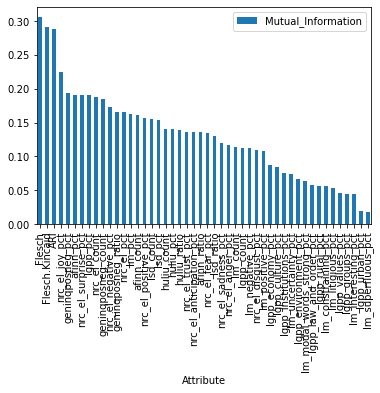

,Attribute,Mutual_Information
0,Flesch,0.305969
2,Flesch.Kincaid,0.291483
1,ARI,0.288584
38,nrc_el_joy_pct,0.225144
8,geninqposneg_pct,0.194399
6,afinn_pct,0.191323
42,nrc_el_surprise_pct,0.191276
22,lgpp_pct,0.190892
32,nrc_el_count,0.187693
7,geninqposneg_count,0.185126


In [18]:
X = df_training_videos_num_i.to_numpy()[:,1:]
y = df_training_videos_num_i.to_numpy()[:,0].astype('int')
mic = mutual_info_classif(X, y, random_state=seed)
columns = df_training_videos_num_i.columns[1:]
mic_df = pd.DataFrame({'Attribute':df_training_videos_num_i.columns[1:], 'Mutual_Information':mic}).sort_values(by="Mutual_Information", ascending=False)
mic_df.plot('Attribute', 'Mutual_Information', kind='bar')
plt.show()
mic_df

,Flesch,ARI,Flesch.Kincaid,lsd_count,lsd_pct,afinn_count,afinn_pct,geninqposneg_count,geninqposneg_pct,huliu_count,...,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct,lsd_ratio,afinn_ratio,geninqposneg_ratio,huliu_ratio
Flesch,1.000000,-0.999991,-0.999991,-0.697051,-0.019915,-0.678471,0.010709,-0.693495,-0.103005,-0.679150,...,0.022110,-0.028059,-0.147144,-0.009372,0.101113,-0.142831,0.003117,0.003244,-0.052106,-0.019812
ARI,-0.999991,1.000000,0.999999,0.697106,0.019968,0.678734,-0.009942,0.693737,0.104151,0.679306,...,-0.020838,0.027463,0.146767,0.009069,-0.100046,0.142363,-0.002511,-0.002472,0.052790,0.020482
Flesch.Kincaid,-0.999991,0.999999,1.000000,0.697005,0.019165,0.678607,-0.010623,0.693625,0.103159,0.679191,...,-0.021438,0.027041,0.146029,0.008693,-0.100658,0.141696,-0.002797,-0.002779,0.052308,0.020172
lsd_count,-0.697051,0.697106,0.697005,1.000000,0.103384,0.984097,0.062515,0.980463,0.166164,0.989183,...,0.032802,0.033519,0.158956,-0.006202,-0.026827,0.136196,0.006543,0.015157,0.063702,0.021781
lsd_pct,-0.019915,0.019968,0.019165,0.103384,1.000000,0.097964,0.757149,0.048444,0.724525,0.083539,...,0.329030,0.210933,0.178563,0.199204,0.294910,0.167453,0.139521,0.127053,0.225394,0.109238
afinn_count,-0.678471,0.678734,0.678607,0.984097,0.097964,1.000000,0.108543,0.982227,0.199112,0.986513,...,0.075094,0.016653,0.151238,-0.005106,-0.000659,0.124403,0.024202,0.038777,0.084845,0.042007
afinn_pct,0.010709,-0.009942,-0.010623,0.062515,0.757149,0.108543,1.000000,0.043531,0.707988,0.063844,...,0.424243,0.051132,0.111629,0.143207,0.351662,0.092809,0.190550,0.199419,0.257608,0.162329
geninqposneg_count,-0.693495,0.693737,0.693625,0.980463,0.048444,0.982227,0.043531,1.000000,0.185882,0.983519,...,0.057567,0.008319,0.170015,-0.017776,-0.011253,0.138569,0.026791,0.038691,0.081810,0.044827
geninqposneg_pct,-0.103005,0.104151,0.103159,0.166164,0.724525,0.199112,0.707988,0.185882,1.000000,0.172363,...,0.523776,0.078633,0.302353,0.130643,0.440604,0.230326,0.269912,0.281831,0.368108,0.269614
huliu_count,-0.679150,0.679306,0.679191,0.989183,0.083539,0.986513,0.063844,0.983519,0.172363,1.000000,...,0.041172,0.035985,0.152815,0.000688,-0.020499,0.126833,0.009009,0.021064,0.061973,0.027721


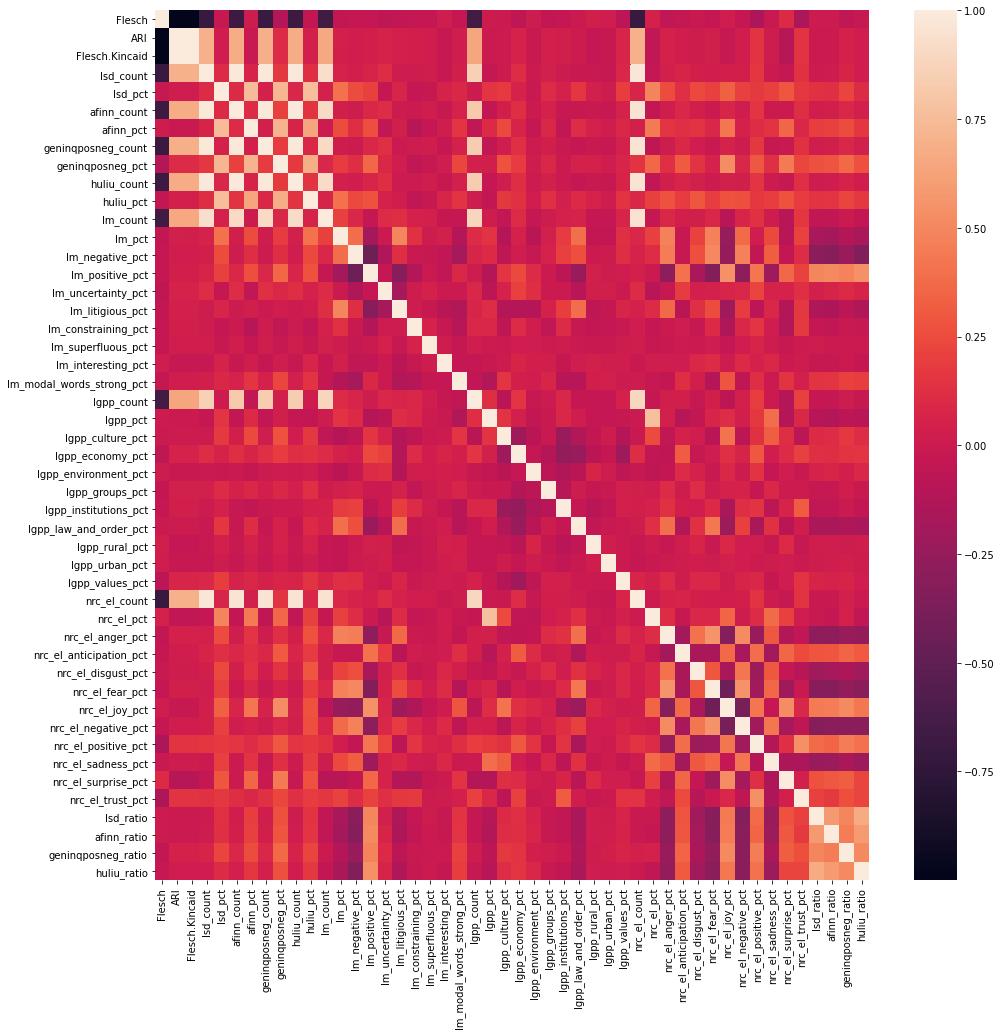

In [19]:
plt.figure(figsize=(16, 16))
sn.heatmap(df_training_videos_num_i.iloc[:,1:].corr())
df_training_videos_num_i.iloc[:,1:].corr()

,Flesch,lsd_count,lsd_pct,lm_pct,lm_negative_pct,lm_positive_pct,lm_uncertainty_pct,lm_litigious_pct,lm_constraining_pct,lm_superfluous_pct,...,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct,lsd_ratio,afinn_ratio,geninqposneg_ratio,huliu_ratio
Flesch,1.000000,-0.697051,-0.019915,-0.040217,-0.030911,-0.036609,-0.057035,-0.045891,-0.032847,-0.027274,...,0.022110,-0.028059,-0.147144,-0.009372,0.101113,-0.142831,0.003117,0.003244,-0.052106,-0.019812
lsd_count,-0.697051,1.000000,0.103384,0.057145,0.036456,0.068687,0.110690,0.012530,0.014818,0.030390,...,0.032802,0.033519,0.158956,-0.006202,-0.026827,0.136196,0.006543,0.015157,0.063702,0.021781
lsd_pct,-0.019915,0.103384,1.000000,0.400965,0.256614,0.208584,-0.023483,0.073112,-0.034748,-0.021036,...,0.329030,0.210933,0.178563,0.199204,0.294910,0.167453,0.139521,0.127053,0.225394,0.109238
lm_pct,-0.040217,0.057145,0.400965,1.000000,0.388612,-0.194322,-0.006173,0.498950,0.135762,0.013959,...,-0.248592,0.378773,0.022635,0.239677,-0.088141,0.215104,-0.165778,-0.190515,-0.110117,-0.163975
lm_negative_pct,-0.030911,0.036456,0.256614,0.388612,1.000000,-0.441333,-0.125787,0.121414,-0.008855,-0.020724,...,-0.252436,0.469365,-0.042219,0.324298,-0.040468,0.113188,-0.303992,-0.318354,-0.230857,-0.339847
lm_positive_pct,-0.036609,0.068687,0.208584,-0.194322,-0.441333,1.000000,-0.036238,-0.314905,-0.108849,-0.005994,...,0.541908,-0.283438,0.427101,-0.207326,0.365242,0.213654,0.497181,0.513901,0.478204,0.544534
lm_uncertainty_pct,-0.057035,0.110690,-0.023483,-0.006173,-0.125787,-0.036238,1.000000,-0.177092,0.014303,0.047637,...,0.071081,0.082045,0.219749,0.054810,0.061254,0.131016,0.046498,0.065848,0.095495,0.064566
lm_litigious_pct,-0.045891,0.012530,0.073112,0.498950,0.121414,-0.314905,-0.177092,1.000000,0.014705,-0.018009,...,-0.217249,0.181394,-0.075807,0.091983,-0.115624,0.169867,-0.131180,-0.141672,-0.069173,-0.140379
lm_constraining_pct,-0.032847,0.014818,-0.034748,0.135762,-0.008855,-0.108849,0.014303,0.014705,1.000000,0.059624,...,-0.131160,0.082368,0.156241,0.015908,-0.119800,0.173788,-0.032690,-0.048585,-0.014504,-0.020461
lm_superfluous_pct,-0.027274,0.030390,-0.021036,0.013959,-0.020724,-0.005994,0.047637,-0.018009,0.059624,1.000000,...,-0.032798,0.018480,0.065006,0.007955,-0.022218,0.005485,0.009856,-0.007215,-0.004085,-0.006763


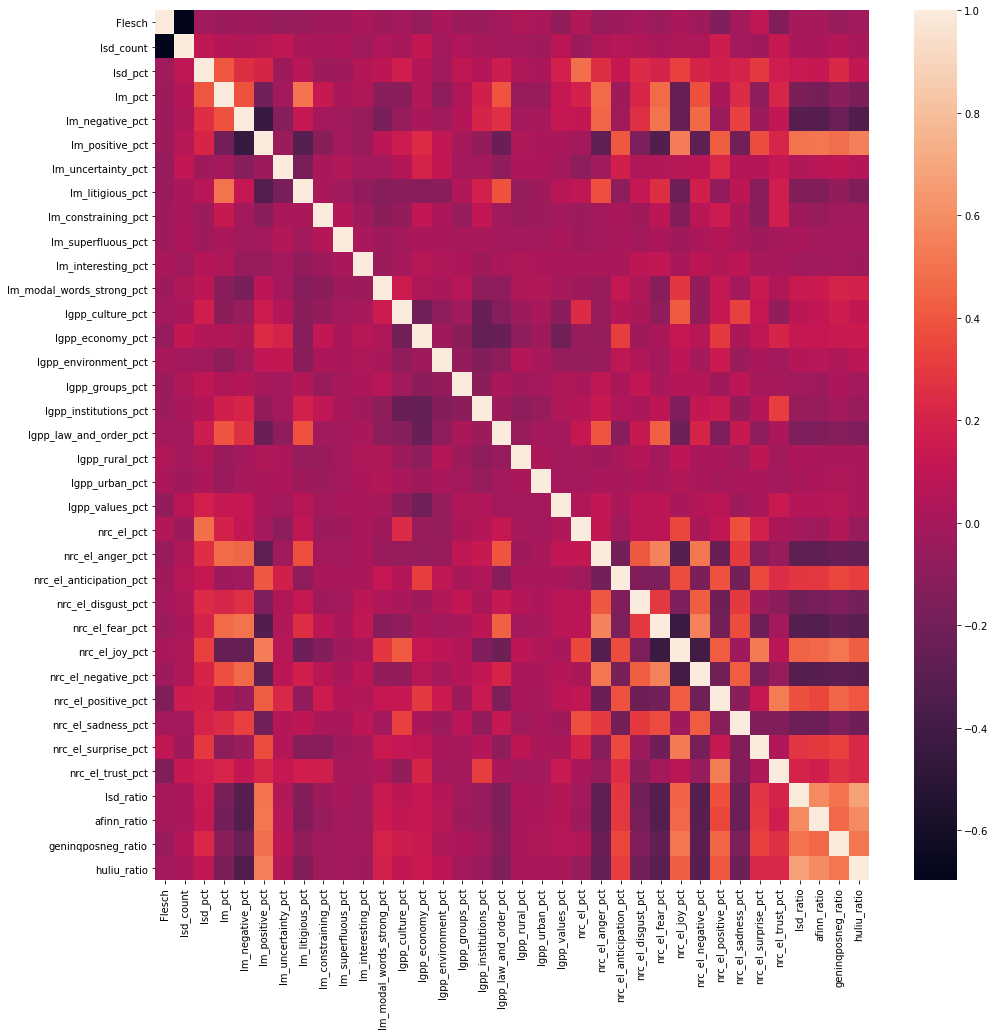

In [20]:
feature_drop = ["ARI", "Flesch.Kincaid", "afinn_count", "geninqposneg_count", "huliu_count", "lm_count", "lgpp_count", "nrc_el_count", "lgpp_pct", "afinn_pct", "geninqposneg_pct", "huliu_pct"]
df_training_videos_num_i = df_training_videos_num_i.drop(feature_drop, axis = 1)
plt.figure(figsize=(16, 16))
sn.heatmap(df_training_videos_num_i.iloc[:,1:].corr())
df_training_videos_num_i.iloc[:,1:].corr()

In [21]:
X = df_training_videos_num_i.to_numpy()[:, 1:]
y = df_training_videos_num_i.to_numpy()[:, 0].astype('int')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## KNN

In [23]:
knn_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [24]:
parametres = [{"n_neighbors":[10, 20, 30, 40, 50, 60]}]
grid_knn = GridSearchCV(cv = 10, estimator=KNeighborsClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)
grille_knn = grid_knn.fit(X_train, y_train)

best_estimators_knn = grille_knn.best_params_["n_neighbors"]
print("Best neighbors: ", best_estimators_knn)

best_score_knn = grille_knn.best_score_
print("Best score: ", best_score_knn)

knn = KNeighborsClassifier(n_neighbors=best_estimators_knn)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)

print("Random Forest Accuracy: ", knn_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best neighbors:  10
Best score:  0.5112362465473301
Random Forest Accuracy:  0.5049407114624506


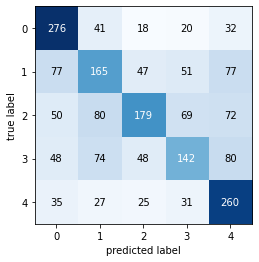

In [25]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_knn))
plt.show()

In [26]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_knn, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

knn_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", knn_accuracy)

Accuracy:  0.5049407114624506


In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

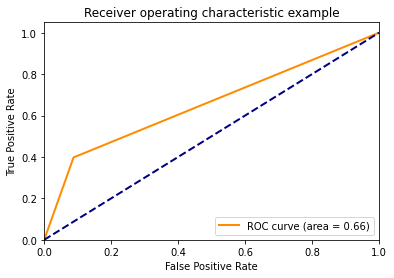

In [28]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

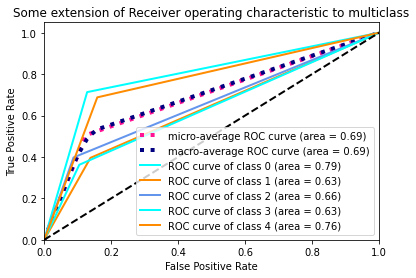

In [29]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [30]:
knn_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Gaussian Naive Bayes

In [31]:
gnb_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [32]:
#parametres = [{"n_neighbors":[10, 20, 30, 40, 50, 60]}]
#grid_gnb = GridSearchCV(cv = 10, estimator=KNeighborsClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)

#grille_gnb = grid_gnb.fit(X_train, y_train)

#best_estimators_gnb = grille_gnb.best_params_["n_neighbors"]
#print("Best neighbors: ", best_estimators_gnb)

#best_score_gnb = grille_gnb.best_score_
#print("Best score: ", best_score_gnb)

gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred_gnb = gnb.predict(X_test)

gnb_accuracy = metrics.accuracy_score(y_test, y_pred_gnb)

print("Random Forest Accuracy: ", gnb_accuracy)

Random Forest Accuracy:  0.3799407114624506


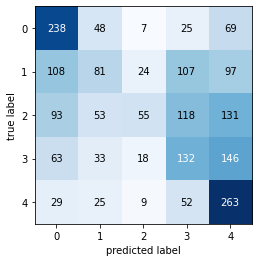

In [33]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_gnb))
plt.show()

In [34]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_gnb, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

gnb_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", gnb_accuracy)

Accuracy:  0.3799407114624506


In [35]:
gnb_end = time.strftime("%Y-%m-%d_%H_%M_%S")

##  Random Forest

In [36]:
rf_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [37]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
grid_rf = GridSearchCV(cv = 10, estimator=RandomForestClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)
grille_rf = grid_rf.fit(X_train, y_train)

best_estimators_rf = grille_rf.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_rf)

best_score_rf = grille_rf.best_score_
print("Best score: ", best_score_rf)

rf = RandomForestClassifier(n_estimators=best_estimators_rf, random_state=seed)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy: ", rf_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 13.4min finished


Best estimators:  350
Best score:  0.6451313159059348
Random Forest Accuracy:  0.6585968379446641


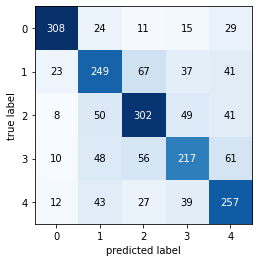

In [38]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_rf))
plt.show()

In [39]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_rf, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

rf_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", rf_accuracy)

Accuracy:  0.6585968379446641


In [40]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

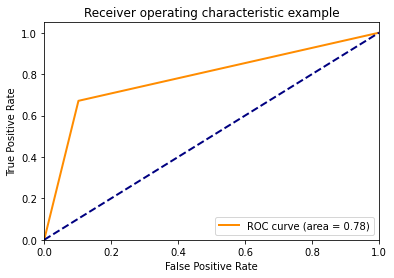

In [41]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

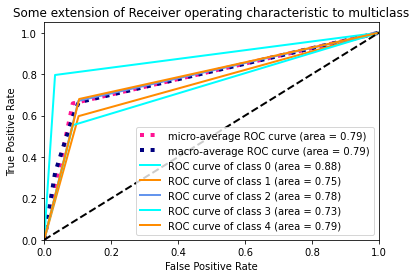

In [42]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [43]:
rf_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Bagging (Decision Tree Classifier)

In [44]:
bag_dtc_start = time.strftime("%Y-%m-%d_%H_%M_%S")

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 63.5min finished


Best estimators:  250
Best score:  0.6427819743930169
Bagging (Decision Tree Classifier) Accuracy:  0.6452569169960475


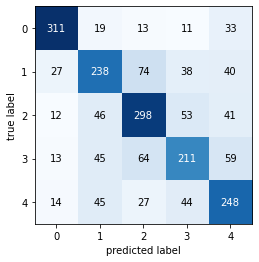

Accuracy:  0.6452569169960475


In [45]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
bag_dtc = BaggingClassifier(DecisionTreeClassifier(), random_state=seed)
grid_bag_dtc = GridSearchCV(cv = 10, estimator=bag_dtc, param_grid=parametres, scoring="accuracy", verbose=1)
grille_bag_dtc = grid_bag_dtc.fit(X_train, y_train)

best_estimators_bag_dtc = grille_bag_dtc.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_bag_dtc)

best_score_bag_dtc = grille_bag_dtc.best_score_
print("Best score: ", best_score_bag_dtc)

bag_dtc = BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_estimators_bag_dtc, random_state=seed)
bag_dtc.fit(X_train,y_train)
y_pred_bag_dtc = bag_dtc.predict(X_test)

bag_dtc_accuracy = metrics.accuracy_score(y_test, y_pred_bag_dtc)

print("Bagging (Decision Tree Classifier) Accuracy: ", bag_dtc_accuracy)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_bag_dtc))
plt.show()

y_pred_b = label_binarize(y_pred_bag_dtc, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

bag_dtc_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)
print("Accuracy: ", bag_dtc_accuracy)

In [46]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

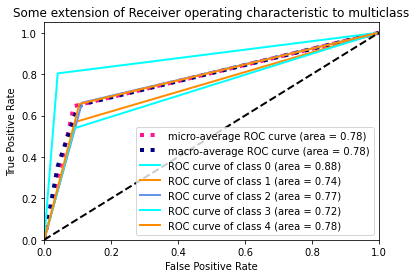

In [47]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [48]:
bag_dtc_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Bagging (K-Nearest Neighbour)

In [49]:
bag_knn_start = time.strftime("%Y-%m-%d_%H_%M_%S")

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 169.4min finished


Best estimators:  200
Best score:  0.5221060904332433
Bagging (Decision Tree Classifier) Accuracy:  0.6447628458498024


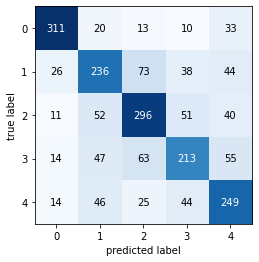

Accuracy:  0.6447628458498024


In [50]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
bag_knn = BaggingClassifier(KNeighborsClassifier(), random_state=seed)
grid_bag_knn = GridSearchCV(cv = 10, estimator=bag_knn, param_grid=parametres, scoring="accuracy", verbose=1)
grille_bag_knn = grid_bag_knn.fit(X_train, y_train)

best_estimators_bag_knn = grille_bag_knn.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_bag_knn)

best_score_bag_knn = grille_bag_knn.best_score_
print("Best score: ", best_score_bag_knn)

bag_knn = BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_estimators_bag_knn, random_state=seed)
bag_knn.fit(X_train, y_train)
y_pred_bag_knn = bag_knn.predict(X_test)

bag_knn_accuracy = metrics.accuracy_score(y_test, y_pred_bag_knn)

print("Bagging (Decision Tree Classifier) Accuracy: ", bag_knn_accuracy)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_bag_knn))
plt.show()

y_pred_b = label_binarize(y_pred_bag_knn, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

bag_knn_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)
print("Accuracy: ", bag_knn_accuracy)

In [51]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

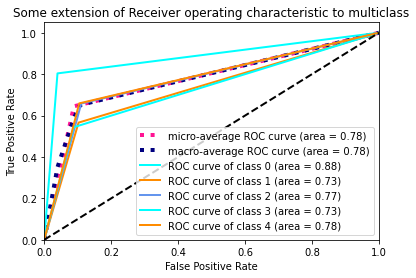

In [52]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [53]:
bag_knn_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Gradient Boosted Trees

In [54]:
cat_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [55]:
X_display = df_training_videos_num_i.drop('bias_num', axis = 1)
y_display = df_training_videos_num_i['bias_num'].to_numpy()

In [56]:
# create a train/test split with catboost
d_test_cat = cat.Pool(X_test, y_test)

In [57]:
model_cat = cat.CatBoostClassifier(iterations = 5000
                                   , learning_rate = 0.01
                                   , loss_function = "MultiClass"
                                   , random_seed = seed
#                                   , depth = 8)
                                   , depth = 4)

model_cat.fit(X_train
                , y_train
                , eval_set = d_test_cat
                , verbose_eval=500
                , early_stopping_rounds=400
                , plot = True)

y_pred_cat_array = model_cat.predict(X_test)

print("\nTest  Accuracy : %.2f"%model_cat.score(X_test, y_test))
print("Train Accuracy : %.2f"%model_cat.score(X_train, y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6046639	test: 1.6047432	best: 1.6047432 (0)	total: 333ms	remaining: 27m 45s
500:	learn: 1.2013930	test: 1.2244584	best: 1.2244584 (500)	total: 13.3s	remaining: 1m 59s
1000:	learn: 1.0993954	test: 1.1512396	best: 1.1512396 (1000)	total: 24.7s	remaining: 1m 38s
1500:	learn: 1.0267990	test: 1.1068586	best: 1.1068586 (1500)	total: 35.7s	remaining: 1m 23s
2000:	learn: 0.9742369	test: 1.0806209	best: 1.0806209 (2000)	total: 47.2s	remaining: 1m 10s
2500:	learn: 0.9342244	test: 1.0625983	best: 1.0625983 (2500)	total: 1m	remaining: 1m
3000:	learn: 0.8991175	test: 1.0485268	best: 1.0485268 (3000)	total: 1m 12s	remaining: 48.4s
3500:	learn: 0.8678285	test: 1.0368842	best: 1.0368842 (3500)	total: 1m 29s	remaining: 38.1s
4000:	learn: 0.8400884	test: 1.0271855	best: 1.0271855 (4000)	total: 1m 42s	remaining: 25.5s
4500:	learn: 0.8146198	test: 1.0186791	best: 1.0186791 (4500)	total: 1m 56s	remaining: 12.9s
4999:	learn: 0.7910393	test: 1.0107315	best: 1.0107282 (4998)	total: 2m 11s	remainin

In [58]:
y_pred_cat = []
for i in range(len(y_pred_cat_array)):
    y_pred_cat.append(y_pred_cat_array[i][0])
y_pred_cat = np.asarray(y_pred_cat)

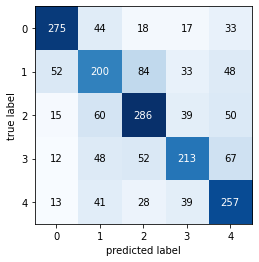

In [59]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_cat))
plt.show()

In [60]:
y_pred_b = label_binarize(y_pred_cat, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

cat_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", cat_accuracy)

Accuracy:  0.608201581027668


In [61]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

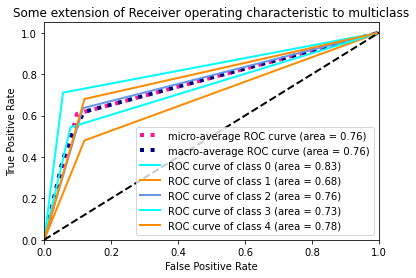

In [62]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [63]:
#file_name = "model/catboost_0" + date + ".cat"
#with open(file_name, 'wb') as fid:
    #cPickle.dump(bag, fid)

In [64]:
cat_end = time.strftime("%Y-%m-%d_%H_%M_%S")

El método **CatBoost** se detiene luego de 500 iteraciones al detectar posible overfitting, reprotando un error observado de 55% correspondiente a la iteración 390.

Además se probó una profundidad máxima de 4, arrojando el mismo error, llegando al resultado en 1247 iteraciones. También se probaron varios learning rate (0.02, 0.05, 0.001) con 4 de profundidad, obteninedo prácticamente el mismo error, con la notable diferencia de learning_rate de 0.001 que subía casi dos puntos.

Se conserva el modelo con depth=8 y learning_rate=0.01 como final.

## XGBoost

In [65]:
xgb_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [66]:
# create a train/test split with xgboost
d_train_xgb = xgb.DMatrix(X_train, label=y_train)
d_test_xgb = xgb.DMatrix(X_test, label=y_test)

params = {
    "learning_rate": 0.01,
    "objective": "multi:softmax",
    "num_class": 6,
    "eval_metric": "mlogloss",
    "max_depth": 4,
    "max_leaves": 4
}

model_xgb = xgb.train(params
                        , d_train_xgb
                        , 40000
                        , evals = [(d_test_xgb, "Test")]
                        , verbose_eval=1000
                        , early_stopping_rounds=1000)

y_pred_xgb_array = model_xgb.predict(d_test_xgb)
y_train_xgb_array = model_xgb.predict(d_train_xgb)

print("\nTest  Accuracy : %.2f"%accuracy_score(y_test, y_pred_xgb_array))
print("Train Accuracy : %.2f"%accuracy_score(y_train, y_train_xgb_array))

print("\nClassification Report : ")
print(classification_report(y_test, y_pred_xgb_array))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_xgb_array))
plt.show()

y_pred_xgb_array_b = label_binarize(y_pred_xgb_array, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

xgb_accuracy = metrics.accuracy_score(y_test_b, y_pred_xgb_array_b)

print("Accuracy: ", xgb_accuracy)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_xgb_array_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_xgb_array_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(model_xgb, ax=ax, height=0.6, importance_type="weight")

In [67]:
xgb_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Metrics Summary

In [68]:
print("Start time: ", gnb_start)

print("**** Gaussian Naive Bayes ****")
print("")
print("Accuracy: %.2f" % gnb_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_gnb, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_gnb, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_gnb, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_gnb)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_gnb))
print("Elapsed: %.2f" % (abs(datetime.strptime(gnb_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(gnb_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))


print("")
print("")
print("**** KNN ****")
print("")
print("Best Estimators: ", best_estimators_knn)
print("Accuracy: %.2f" % knn_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_knn, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_knn, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_knn, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_knn)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_knn))
print("Elapsed: %.2f" % (abs(datetime.strptime(knn_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(knn_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("**** Random Forest ****")
print("")
print("Best Estimators: ", best_estimators_rf)
print("Accuracy: %.2f" % rf_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_rf, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_rf, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_rf, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_rf)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_rf))
print("Elapsed: %.2f" % (abs(datetime.strptime(rf_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(rf_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Bagging (Decision Tree Classifier) ****")
print("")
print("Best Estimators: ", best_estimators_bag_dtc)
print("Accuracy: %.2f" % bag_dtc_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_bag_dtc)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_bag_dtc))
print("Elapsed: %.2f" % (abs(datetime.strptime(bag_dtc_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(bag_dtc_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Bagging (K-Nearest Neighbours) ****")
print("")
print("Best Estimators: ", best_estimators_bag_knn)
print("Accuracy: %.2f" % bag_knn_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_bag_knn)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_bag_knn))
print("Elapsed: %.2f" % (abs(datetime.strptime(bag_knn_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(bag_knn_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Catboost ****")
print("")
print("Accuracy: %.2f" % cat_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_cat, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_cat, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_cat, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_cat)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_cat))
print("Elapsed: %.2f" % (abs(datetime.strptime(cat_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(cat_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** XGBoost ****")
print("")
#print("Accuracy: %.2f" % xgb_accuracy)
#print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="micro"))
#print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="macro"))
#print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="weighted"))

#precision, recall, fscore, support = score(y_test, y_pred_xgb_array)

#print("precision: {}".format(precision))
#print("recall: {}".format(recall))
#print("fscore: {}".format(fscore))
#print("support: {}".format(support))

#print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_xgb_array))
print("Elapsed: %.2f" % (abs(datetime.strptime(xgb_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(xgb_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("End time: ", xgb_end)

Start time:  2022-01-26_14_50_31
**** Gaussian Naive Bayes ****

Accuracy: 0.38
F1 Scode micro: 0.38
F1 Scode macro: 0.35
F1 Scode weighted: 0.35
precision: [0.44821092 0.3375     0.48672566 0.30414747 0.37252125]
recall: [0.61498708 0.1942446  0.12222222 0.33673469 0.6957672 ]
fscore: [0.51851852 0.24657534 0.19538188 0.31961259 0.48523985]
support: [387 417 450 392 378]
MEA: 1.16
Elapsed: 0.02


**** KNN ****

Best Estimators:  10
Accuracy: 0.50
F1 Scode micro: 0.50
F1 Scode macro: 0.50
F1 Scode weighted: 0.50
precision: [0.56790123 0.42635659 0.56466877 0.45367412 0.49904031]
recall: [0.71317829 0.39568345 0.39777778 0.3622449  0.68783069]
fscore: [0.63230241 0.41044776 0.46675359 0.40283688 0.57842047]
support: [387 417 450 392 378]
MEA: 0.91
Elapsed: 1.18
**** Random Forest ****

Best Estimators:  350
Accuracy: 0.66
F1 Scode micro: 0.66
F1 Scode macro: 0.66
F1 Scode weighted: 0.66
precision: [0.8531856  0.60144928 0.65226782 0.60784314 0.5990676 ]
recall: [0.79586563 0.5971223  0.

# Classifying Unique Videos Dataset

In [69]:
#df_unique_videos = pd.read_csv("./model/unique_videos_attributes2022-01-16_09_59_01.csv")
df_unique_videos = pd.read_csv("./model/unique_videos_attributes_and_model_inputs2022-01-15_16_09_11.csv")
print("Number of records (unique set):", len(df_unique_videos))
df_unique_videos.head()

Number of records (unique set): 56424


,video,duration,view_count,width,height,channel_id,channel_title,published_time,status,length,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
0,kisC2LWRnAE,4:37,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,2 weeks ago,Success,660.0,...,0.099291,0.078014,0.056738,0.120567,0.056738,0.212766,0.163121,0.070922,0.028369,0.113475
1,7T9D4Eqs2Jk,2:48,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,412.0,...,0.083333,0.068182,0.030303,0.113636,0.075758,0.136364,0.204545,0.098485,0.060606,0.128788
2,Sl_bKxcJOSk,9:07,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1568.0,...,0.090909,0.055718,0.026393,0.061584,0.052786,0.117302,0.199413,0.073314,0.149560,0.173021
3,9LoKfCbxVDE,10:16,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1815.0,...,0.117978,0.075843,0.030899,0.089888,0.053371,0.154494,0.205056,0.058989,0.070225,0.143258
4,0W9OYSuyB3k,5:44,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,971.0,...,0.078341,0.119816,0.018433,0.064516,0.064516,0.147465,0.216590,0.041475,0.115207,0.133641


In [70]:
df_unique_videos.loc[df_unique_videos["bias"]=="L", "bias_num"] = 1
df_unique_videos.loc[df_unique_videos["bias"]=="LC", "bias_num"] = 2
df_unique_videos.loc[df_unique_videos["bias"]=="C", "bias_num"] = 3
df_unique_videos.loc[df_unique_videos["bias"]=="RC", "bias_num"] = 4
df_unique_videos.loc[df_unique_videos["bias"]=="R", "bias_num"] = 5

In [71]:
df_unique_videos["lsd_count"] = df_unique_videos["lsd_negative"] + df_unique_videos["lsd_positive"]
df_unique_videos["lsd_pct"] = df_unique_videos["lsd_count"] / df_unique_videos["length"]

df_unique_videos["afinn_count"] = df_unique_videos["afinn_negative"] + df_unique_videos["afinn_positive"]
df_unique_videos["afinn_pct"] = df_unique_videos["afinn_count"] / df_unique_videos["length"]

df_unique_videos["geninqposneg_count"] = df_unique_videos["geninqposneg_negative"] + df_unique_videos["geninqposneg_positive"]
df_unique_videos["geninqposneg_pct"] = df_unique_videos["geninqposneg_count"] / df_unique_videos["length"]

df_unique_videos["huliu_count"] = df_unique_videos["huliu_negative"] + df_unique_videos["huliu_positive"]
df_unique_videos["huliu_pct"] = df_unique_videos["huliu_count"] / df_unique_videos["length"]

df_unique_videos["lm_count"] = df_unique_videos["lm_negative"] + df_unique_videos["lm_positive"] + df_unique_videos["lm_uncertainty"] + df_unique_videos["lm_litigious"] + df_unique_videos["lm_constraining"] + df_unique_videos["lm_superfluous"] + df_unique_videos["lm_interesting"] + df_unique_videos["lm_modal_words_strong"]
df_unique_videos["lm_pct"] = df_unique_videos["lm_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_negative_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_positive_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_uncertainty_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_litigious_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_constraining_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_superfluous_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_interesting_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_modal_words_strong_pct"] = 0

df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_negative_pct"] = df_unique_videos["lm_negative"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_positive_pct"] = df_unique_videos["lm_positive"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_uncertainty_pct"] = df_unique_videos["lm_uncertainty"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_litigious_pct"] = df_unique_videos["lm_litigious"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_constraining_pct"] = df_unique_videos["lm_constraining"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_superfluous_pct"] = df_unique_videos["lm_superfluous"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_interesting_pct"] = df_unique_videos["lm_interesting"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_modal_words_strong_pct"] = df_unique_videos["lm_modal_words_strong"] / df_unique_videos["lm_count"]

df_unique_videos["lgpp_count"] = df_unique_videos["lgpp_culture"] + df_unique_videos["lgpp_economy"] + df_unique_videos["lgpp_environment"] + df_unique_videos["lgpp_groups"] + df_unique_videos["lgpp_institutions"] + df_unique_videos["lgpp_law_and_order"] + df_unique_videos["lgpp_rural"] + df_unique_videos["lgpp_urban"] + df_unique_videos["lgpp_values"]
df_unique_videos["lgpp_pct"] = df_unique_videos["lgpp_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_culture_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_economy_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_environment_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_groups_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_institutions_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_law_and_order_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_rural_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_urban_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_values_pct"] = 0

df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_culture_pct"] = df_unique_videos["lgpp_culture"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_economy_pct"] = df_unique_videos["lgpp_economy"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_environment_pct"] = df_unique_videos["lgpp_environment"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_groups_pct"] = df_unique_videos["lgpp_groups"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_institutions_pct"] = df_unique_videos["lgpp_institutions"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_law_and_order_pct"] = df_unique_videos["lgpp_law_and_order"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_rural_pct"] = df_unique_videos["lgpp_rural"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_urban_pct"] = df_unique_videos["lgpp_urban"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_values_pct"] = df_unique_videos["lgpp_values"] / df_unique_videos["lgpp_count"]

df_unique_videos["nrc_el_count"] = df_unique_videos["nrc_el_anger"] + df_unique_videos["nrc_el_anticipation"] + df_unique_videos["nrc_el_disgust"] + df_unique_videos["nrc_el_fear"] + df_unique_videos["nrc_el_joy"] + df_unique_videos["nrc_el_negative"] + df_unique_videos["nrc_el_positive"] + df_unique_videos["nrc_el_sadness"] + df_unique_videos["nrc_el_surprise"] + df_unique_videos["nrc_el_trust"]
df_unique_videos["nrc_el_pct"] = df_unique_videos["nrc_el_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_anger_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_anticipation_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_disgust_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_fear_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_joy_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_negative_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_positive_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_sadness_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_surprise_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_trust_pct"] = 0

df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_anger_pct"] = df_unique_videos["nrc_el_anger"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_anticipation_pct"] = df_unique_videos["nrc_el_anticipation"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_disgust_pct"] = df_unique_videos["nrc_el_disgust"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_fear_pct"] = df_unique_videos["nrc_el_fear"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_joy_pct"] = df_unique_videos["nrc_el_joy"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_negative_pct"] = df_unique_videos["nrc_el_negative"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_positive_pct"] = df_unique_videos["nrc_el_positive"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_sadness_pct"] = df_unique_videos["nrc_el_sadness"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_surprise_pct"] = df_unique_videos["nrc_el_surprise"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_trust_pct"] = df_unique_videos["nrc_el_trust"] / df_unique_videos["nrc_el_count"]

In [72]:
col = df_unique_videos.pop("lsd_ratio")
df_unique_videos.insert(len(df_unique_videos.columns), "lsd_ratio", col)

col = df_unique_videos.pop("afinn_ratio")
df_unique_videos.insert(len(df_unique_videos.columns), "afinn_ratio", col)

col = df_unique_videos.pop("geninqposneg_ratio")
df_unique_videos.insert(len(df_unique_videos.columns), "geninqposneg_ratio", col)

col = df_unique_videos.pop("huliu_ratio")
df_unique_videos.insert(len(df_unique_videos.columns), "huliu_ratio", col)

In [73]:
df_unique_videos = df_unique_videos[df_unique_videos["length"] > 0]
df_unique_videos.dropna(subset=["Flesch"], inplace=True)

In [74]:
df_unique_videos_att = df_unique_videos[df_unique_videos.columns[56:]]
feature_drop = ["bias", "ARI", "Flesch.Kincaid", "afinn_count", "geninqposneg_count", "huliu_count", "lm_count", "lgpp_count", "nrc_el_count", "lgpp_pct", "huliu_pct", "afinn_pct", "geninqposneg_pct"]

#df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1).fillna(0)
df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1)

bias_col = df_unique_videos_att.pop("bias_num")
df_unique_videos_att.insert(0, "bias_num", bias_col)

In [75]:
df_unique_videos_att.columns

Index(['bias_num', 'Flesch', 'lsd_count', 'lsd_pct', 'lm_pct',
       'lm_negative_pct', 'lm_positive_pct', 'lm_uncertainty_pct',
       'lm_litigious_pct', 'lm_constraining_pct', 'lm_superfluous_pct',
       'lm_interesting_pct', 'lm_modal_words_strong_pct', 'lgpp_culture_pct',
       'lgpp_economy_pct', 'lgpp_environment_pct', 'lgpp_groups_pct',
       'lgpp_institutions_pct', 'lgpp_law_and_order_pct', 'lgpp_rural_pct',
       'lgpp_urban_pct', 'lgpp_values_pct', 'nrc_el_pct', 'nrc_el_anger_pct',
       'nrc_el_anticipation_pct', 'nrc_el_disgust_pct', 'nrc_el_fear_pct',
       'nrc_el_joy_pct', 'nrc_el_negative_pct', 'nrc_el_positive_pct',
       'nrc_el_sadness_pct', 'nrc_el_surprise_pct', 'nrc_el_trust_pct',
       'lsd_ratio', 'afinn_ratio', 'geninqposneg_ratio', 'huliu_ratio'],
      dtype='object')

In [76]:
df_training_videos_num_i.columns

Index(['bias_num', 'Flesch', 'lsd_count', 'lsd_pct', 'lm_pct',
       'lm_negative_pct', 'lm_positive_pct', 'lm_uncertainty_pct',
       'lm_litigious_pct', 'lm_constraining_pct', 'lm_superfluous_pct',
       'lm_interesting_pct', 'lm_modal_words_strong_pct', 'lgpp_culture_pct',
       'lgpp_economy_pct', 'lgpp_environment_pct', 'lgpp_groups_pct',
       'lgpp_institutions_pct', 'lgpp_law_and_order_pct', 'lgpp_rural_pct',
       'lgpp_urban_pct', 'lgpp_values_pct', 'nrc_el_pct', 'nrc_el_anger_pct',
       'nrc_el_anticipation_pct', 'nrc_el_disgust_pct', 'nrc_el_fear_pct',
       'nrc_el_joy_pct', 'nrc_el_negative_pct', 'nrc_el_positive_pct',
       'nrc_el_sadness_pct', 'nrc_el_surprise_pct', 'nrc_el_trust_pct',
       'lsd_ratio', 'afinn_ratio', 'geninqposneg_ratio', 'huliu_ratio'],
      dtype='object')

In [77]:
df_unique_videos_att.columns[60:]

Index([], dtype='object')

In [78]:
X_unique = df_unique_videos_att.to_numpy()[:, 1:]
y_unique = rf.predict(X_unique)
new_bias = ["L" if x == 1 else "CL" if x == 2 else "C" if x == 3 else "CR" if x == 4 else "R" for x in y_unique]

In [79]:
df_unique_videos.insert(len(df_unique_videos.columns), "new_bias", new_bias)

In [80]:
date = time.strftime("%Y-%m-%d_%H_%M_%S")
file_name = "model/classified_unique_videos_1" + file_suffix + date + ".csv"
df_unique_videos_att.to_csv(file_name, index=False)

## Merge With Results Dataset

In [81]:
filepaths = ["results/" + f for f in listdir("results/") if f.endswith(".csv")]
df_videos = pd.concat(map(pd.read_csv, filepaths))
print("Retrieved videos:", len(df_videos))

Retrieved videos: 462986


In [82]:
col = df_unique_videos.pop("bias")
df_unique_videos.insert(0, "bias", col)

col = df_unique_videos.pop("channel_id")
df_unique_videos.insert(0, "channel_id", col)

col = df_unique_videos.pop("channel_title")
df_unique_videos.insert(0, "channel_title", col)

col = df_unique_videos.pop("new_bias")
df_unique_videos.insert(0, "new_bias", col)

In [83]:
df_videos = df_videos.merge(df_unique_videos, on = "video", how = "left")

In [84]:
df_videos.bias.value_counts().sort_index()

C     42539
L     16863
LC    36399
R     39414
RC    17398
Name: bias, dtype: int64

In [85]:
df_videos.new_bias.value_counts().sort_index()

CL    127282
CR    227354
Name: new_bias, dtype: int64

In [86]:
file_name = "model/classified_videos_1" + file_suffix + date + ".csv"
df_videos.to_csv(file_name, index=False)